In [1]:
import os
import sys
import cv2
import sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Dense, Conv2D, Flatten, Activation,
                                     Dropout, MaxPooling2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from IPython.display import clear_output

In [2]:
!unzip '/content/drive/MyDrive/Colab Notebooks/Dataset/docs-data.zip'
clear_output()

In [3]:
print(f'Python version {sys.version}')
print(f'Scikit-learn version {sklearn.__version__}')
print(f'Tensorflow version {tf.__version__}')

Python version 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Scikit-learn version 1.2.2
Tensorflow version 2.12.0


In [4]:
dataset_path_img = '/content/training/images'
dataset_path_metadata = '/content/training/metadata.csv'

random_state = 42

In [5]:
df = pd.read_csv(dataset_path_metadata)
df = df.sample(frac=1, ignore_index=True, random_state=random_state)
df.head()

,image,label
0,44_Ovocal-DX.png,Tab. Ovocal-DX
1,31_Osartil.png,Tab. Osartil 100mg
2,15_Resva.png,Tab. Resva 5mg
3,59_Resva.png,Tab. Resva 5mg
4,11_Coralex-DX.png,Tab. Coralex-DX


In [6]:
df.shape

(1758, 2)

In [7]:
def count_samples(df: pd.DataFrame, title: str='', is_save: bool=False) -> None:
    plt.figure(figsize=(15, 8))
    sns.countplot(x=df['label'], palette=['#432371',"#FAAE7B"])
    if title != '':
        plt.title(title)
    plt.xlabel('Medicine classes')
    plt.ylabel('Number of samples')
    plt.xticks(rotation=20, ha='right')
    if is_save:
        plt.savefig('./number-of-samples.png', dpi=300)
    plt.show()

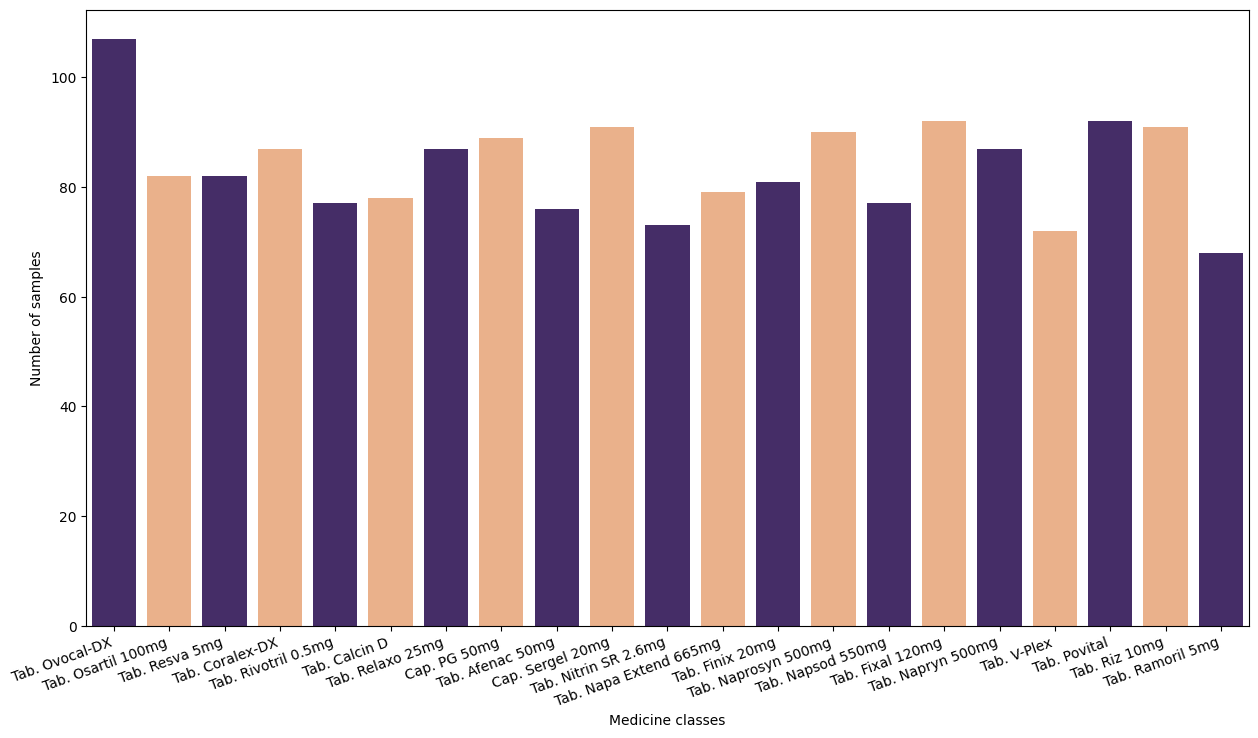

In [8]:
count_samples(df, '', True)

In [9]:
train_dataframe = df.sample(frac=0.8, random_state=random_state)
train_indices = train_dataframe.index

excluding_indices = df.index.isin(train_indices)
test_dataframe = df[~excluding_indices]

print('--Train--')
print(train_dataframe.head())
print(train_dataframe.shape)
print('--Test--')
print(test_dataframe.head())
print(test_dataframe.shape)

--Train--
                image                 label
1125    45_Napsod.png     Tab. Napsod 550mg
1030       80_Riz.png         Tab. Riz 10mg
1450  36_Rivotril.png   Tab. Rivotril 0.5mg
1494     43_Finix.png       Tab. Finix 20mg
344          5_SR.png  Tab. Nitrin SR 2.6mg
(1406, 2)
--Test--
             image                 label
1   31_Osartil.png    Tab. Osartil 100mg
8    57_Relaxo.png      Tab. Relaxo 25mg
13   47_Sergel.png      Cap. Sergel 20mg
14       38_SR.png  Tab. Nitrin SR 2.6mg
20   23_Sergel.png      Cap. Sergel 20mg
(352, 2)


In [10]:
IMG_W = 256
IMG_H = 72
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 50
NO_CLASSES = 21
N_FOLD_SIZE = 5

input_shape = (IMG_H, IMG_W, CHANNELS)

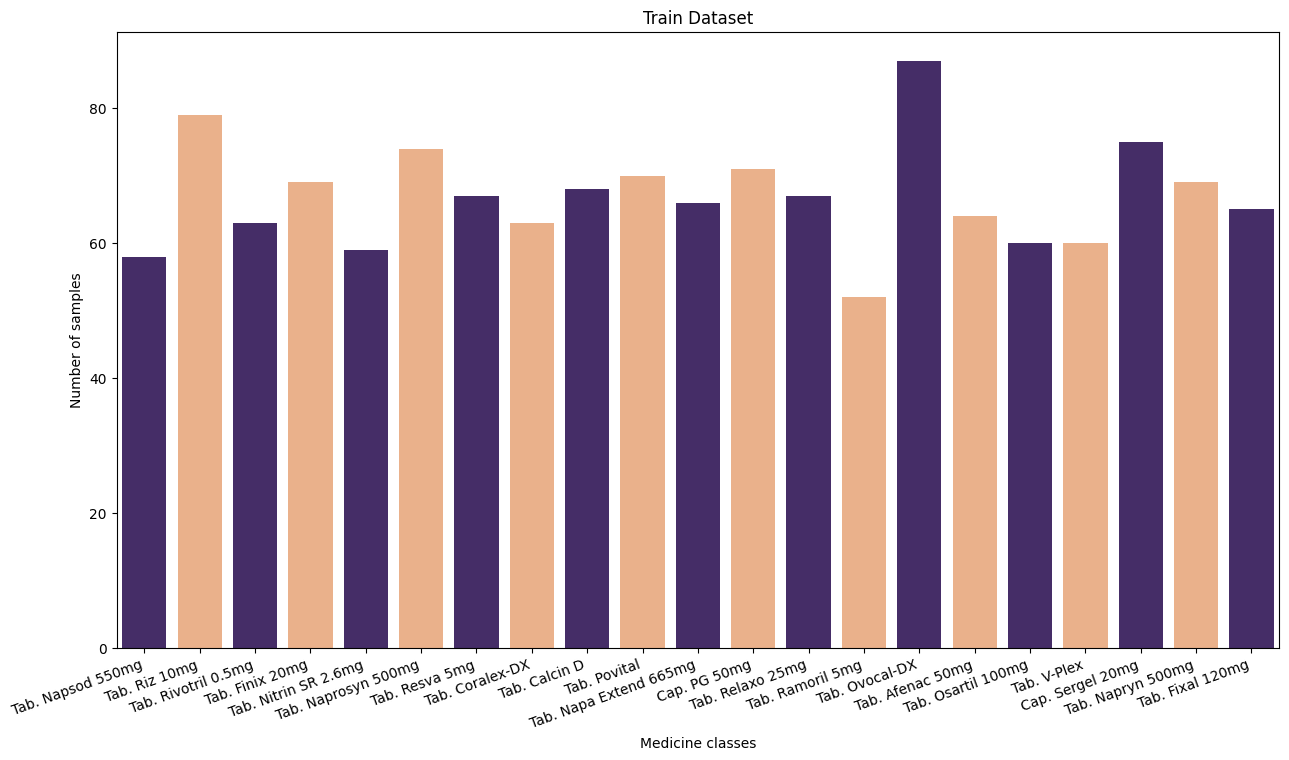

In [11]:
count_samples(train_dataframe, 'Train Dataset')

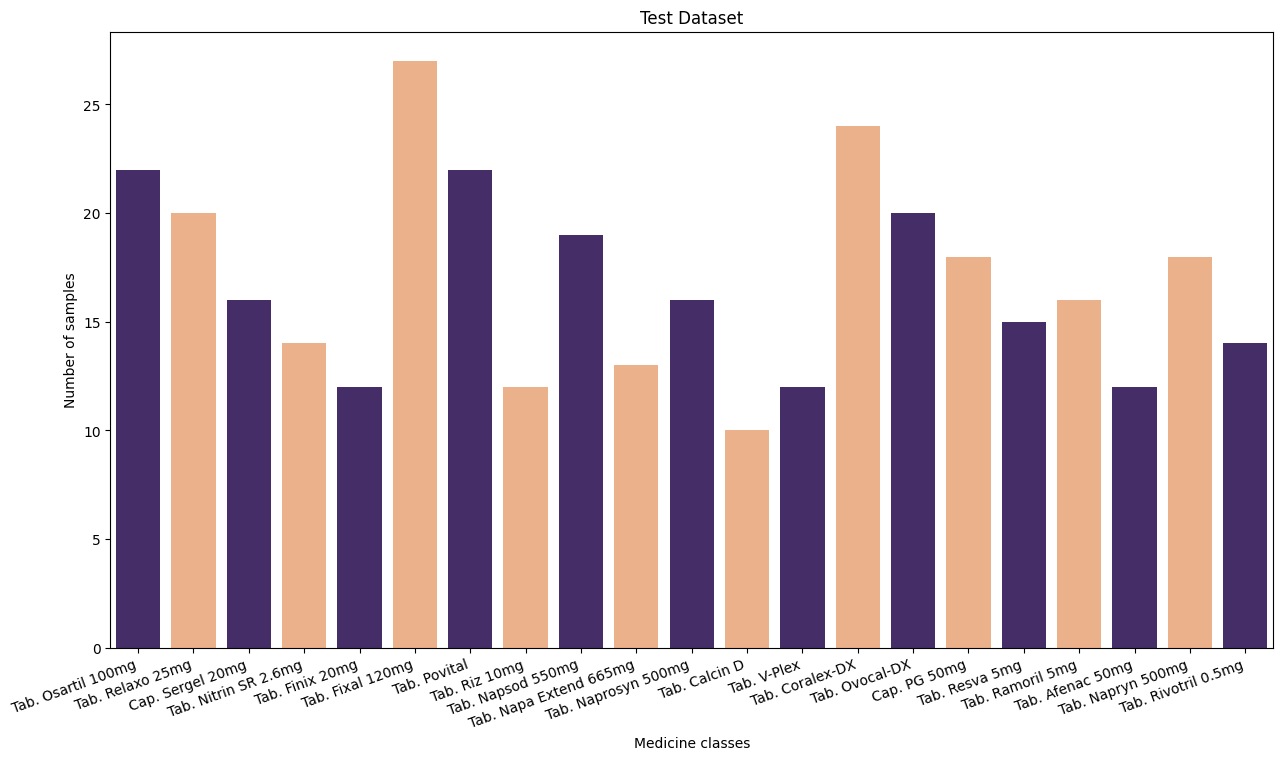

In [12]:
count_samples(test_dataframe, 'Test Dataset')

In [13]:
def plot_accuracy(history, kth=0, model_name=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(25, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(50), acc, label='Training Accuracy')
    plt.plot(range(50), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(
        f'Training and Validation Accuracy {f"for {model_name}" if model_name else ""}')

    plt.subplot(1, 2, 2)
    plt.plot(range(50), loss, label='Training Loss')
    plt.plot(range(50), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(
        f'Training and Validation Loss {f"for {model_name}" if model_name else ""}')
    plt.savefig(f'/content/model_accuracy-{kth}.png')
    plt.show()

In [14]:
def create_model(no_classes):
    model = Sequential([
        # Conv 1
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        # Conv 2
        Conv2D(64,  kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        # Conv 3
        Conv2D(96,  kernel_size=(4, 4), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        # Conv 4
        Conv2D(96, (4, 4), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        # Conv 5
        Conv2D(128, (4, 4), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        # Conv 6
        Conv2D(128, (4, 4), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(no_classes, activation='softmax')
    ])

    return model

## Dataset Generation and Model Training

In [15]:
datagen = ImageDataGenerator(rescale=1./255)

In [16]:
test_set = datagen.flow_from_dataframe(dataframe=test_dataframe,
            directory=dataset_path_img,
            x_col='image', y_col='label',
            class_mode='categorical',
            target_size=(IMG_H, IMG_W),
            batch_size=BATCH_SIZE)

Found 352 validated image filenames belonging to 21 classes.


In [17]:
X = train_dataframe.drop('label', axis=1)
Y = train_dataframe[['label']]

In [18]:
kfold = StratifiedKFold(n_splits=N_FOLD_SIZE, shuffle=True, random_state=random_state)

In [19]:
fold_no = 1
acc_per_fold = []

Fold No. 1
Found 1124 validated image filenames belonging to 21 classes.
Found 282 validated image filenames belonging to 21 classes.
Epoch 1/50
36/36 [==============================] - 19s 100ms/step - loss: 3.0528 - accuracy: 0.0507 - val_loss: 3.0434 - val_accuracy: 0.0567
Epoch 2/50
36/36 [==============================] - 2s 58ms/step - loss: 3.0428 - accuracy: 0.0578 - val_loss: 3.0410 - val_accuracy: 0.0603
Epoch 3/50
36/36 [==============================] - 2s 53ms/step - loss: 3.0434 - accuracy: 0.0623 - val_loss: 3.0416 - val_accuracy: 0.0603
Epoch 4/50
36/36 [==============================] - 2s 52ms/step - loss: 3.0409 - accuracy: 0.0632 - val_loss: 3.0389 - val_accuracy: 0.0603
Epoch 5/50
36/36 [==============================] - 2s 58ms/step - loss: 3.0388 - accuracy: 0.0810 - val_loss: 3.0374 - val_accuracy: 0.0603
Epoch 6/50
36/36 [==============================] - 3s 73ms/step - loss: 2.9624 - accuracy: 0.0979 - val_loss: 2.9556 - val_accuracy: 0.0957
Epoch 7/50
36/36 [

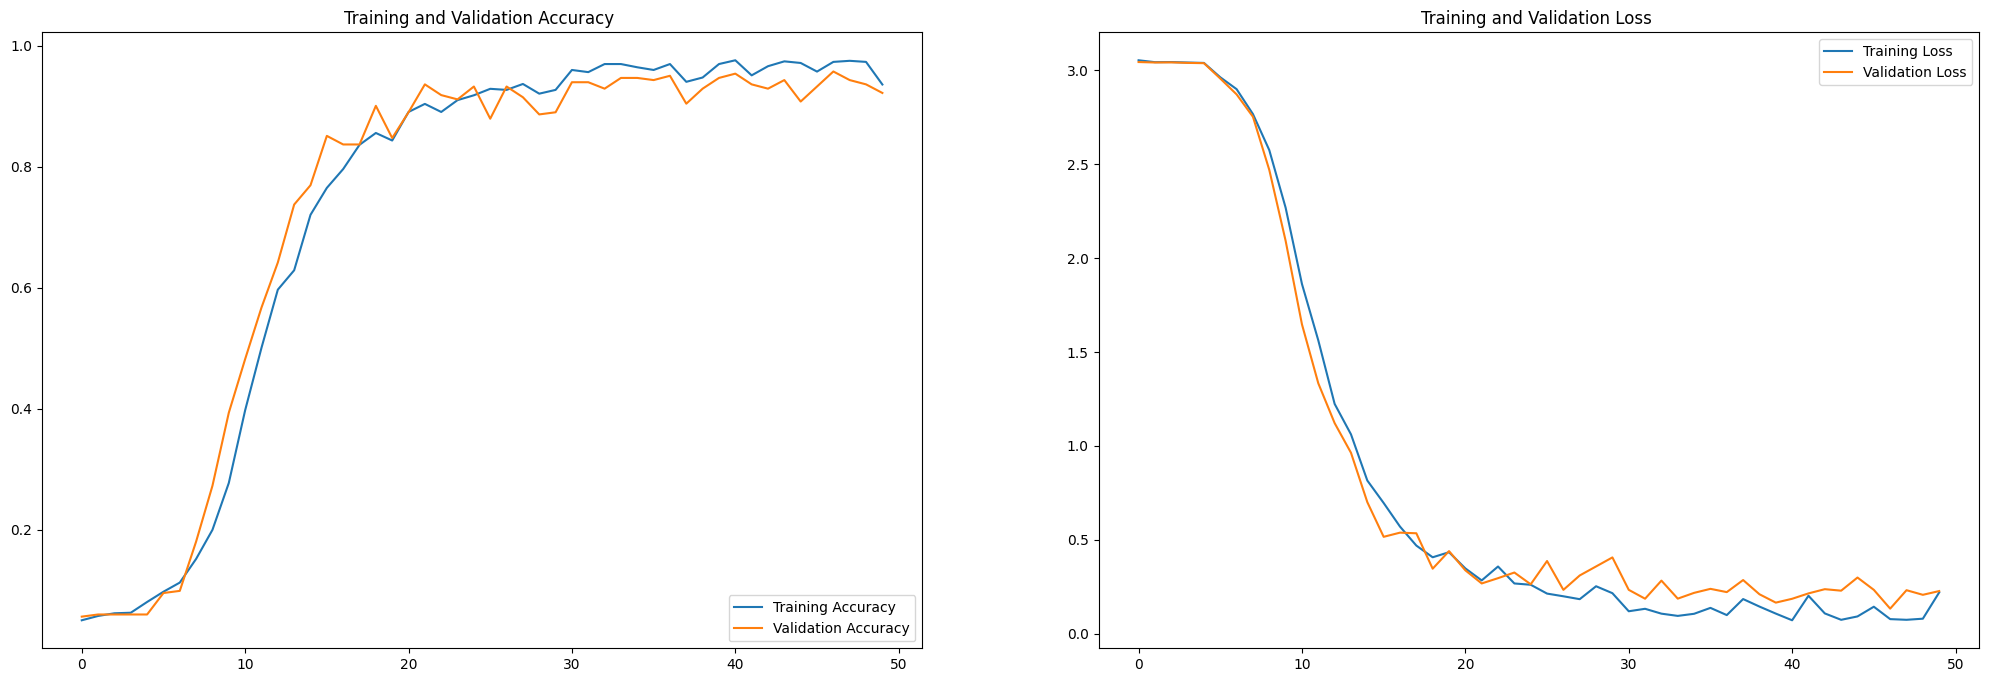

Test Accuracy 92.61363744735718
--------------------------------------------------
Fold No. 2
Found 1125 validated image filenames belonging to 21 classes.
Found 281 validated image filenames belonging to 21 classes.
Epoch 1/50
36/36 [==============================] - 7s 96ms/step - loss: 3.0463 - accuracy: 0.0516 - val_loss: 3.0427 - val_accuracy: 0.0641
Epoch 2/50
36/36 [==============================] - 2s 53ms/step - loss: 3.0458 - accuracy: 0.0560 - val_loss: 3.0406 - val_accuracy: 0.0641
Epoch 3/50
36/36 [==============================] - 3s 79ms/step - loss: 3.0406 - accuracy: 0.0631 - val_loss: 3.0329 - val_accuracy: 0.0498
Epoch 4/50
36/36 [==============================] - 2s 55ms/step - loss: 2.9921 - accuracy: 0.0756 - val_loss: 2.8705 - val_accuracy: 0.1886
Epoch 5/50
36/36 [==============================] - 2s 53ms/step - loss: 2.6978 - accuracy: 0.1778 - val_loss: 2.4003 - val_accuracy: 0.2278
Epoch 6/50
36/36 [==============================] - 2s 53ms/step - loss: 2.311

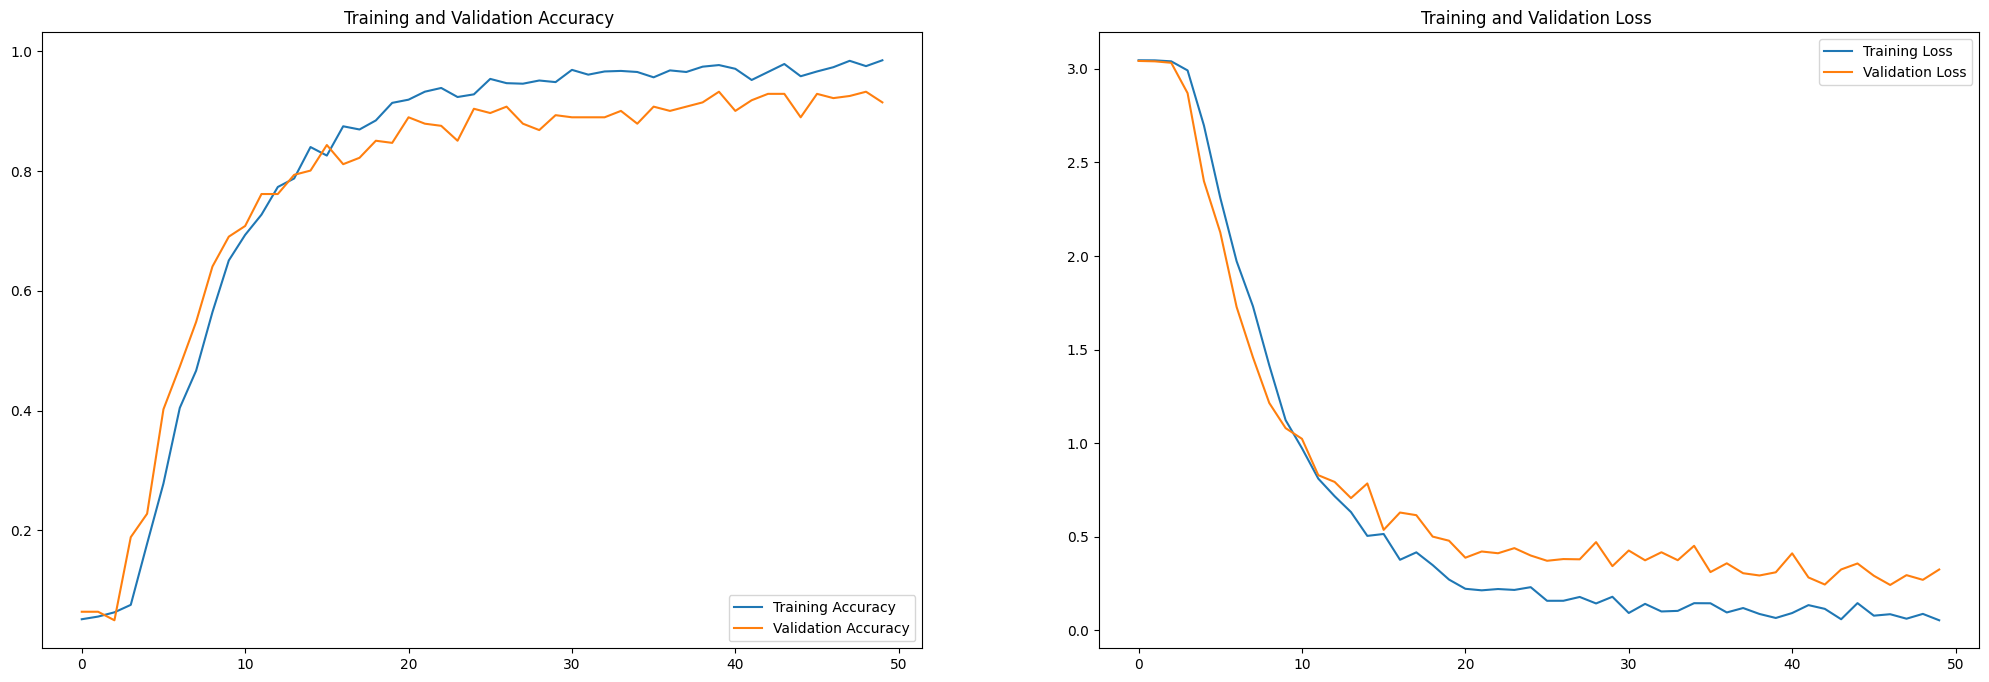

Test Accuracy 91.76136255264282
--------------------------------------------------
Fold No. 3
Found 1125 validated image filenames belonging to 21 classes.
Found 281 validated image filenames belonging to 21 classes.
Epoch 1/50
36/36 [==============================] - 5s 63ms/step - loss: 3.0479 - accuracy: 0.0498 - val_loss: 3.0434 - val_accuracy: 0.0498
Epoch 2/50
36/36 [==============================] - 2s 66ms/step - loss: 3.0435 - accuracy: 0.0542 - val_loss: 3.0426 - val_accuracy: 0.0641
Epoch 3/50
36/36 [==============================] - 3s 77ms/step - loss: 3.0425 - accuracy: 0.0622 - val_loss: 3.0416 - val_accuracy: 0.0641
Epoch 4/50
36/36 [==============================] - 2s 54ms/step - loss: 3.0416 - accuracy: 0.0613 - val_loss: 3.0392 - val_accuracy: 0.0641
Epoch 5/50
36/36 [==============================] - 2s 54ms/step - loss: 3.0436 - accuracy: 0.0498 - val_loss: 3.0411 - val_accuracy: 0.0641
Epoch 6/50
36/36 [==============================] - 2s 53ms/step - loss: 3.041

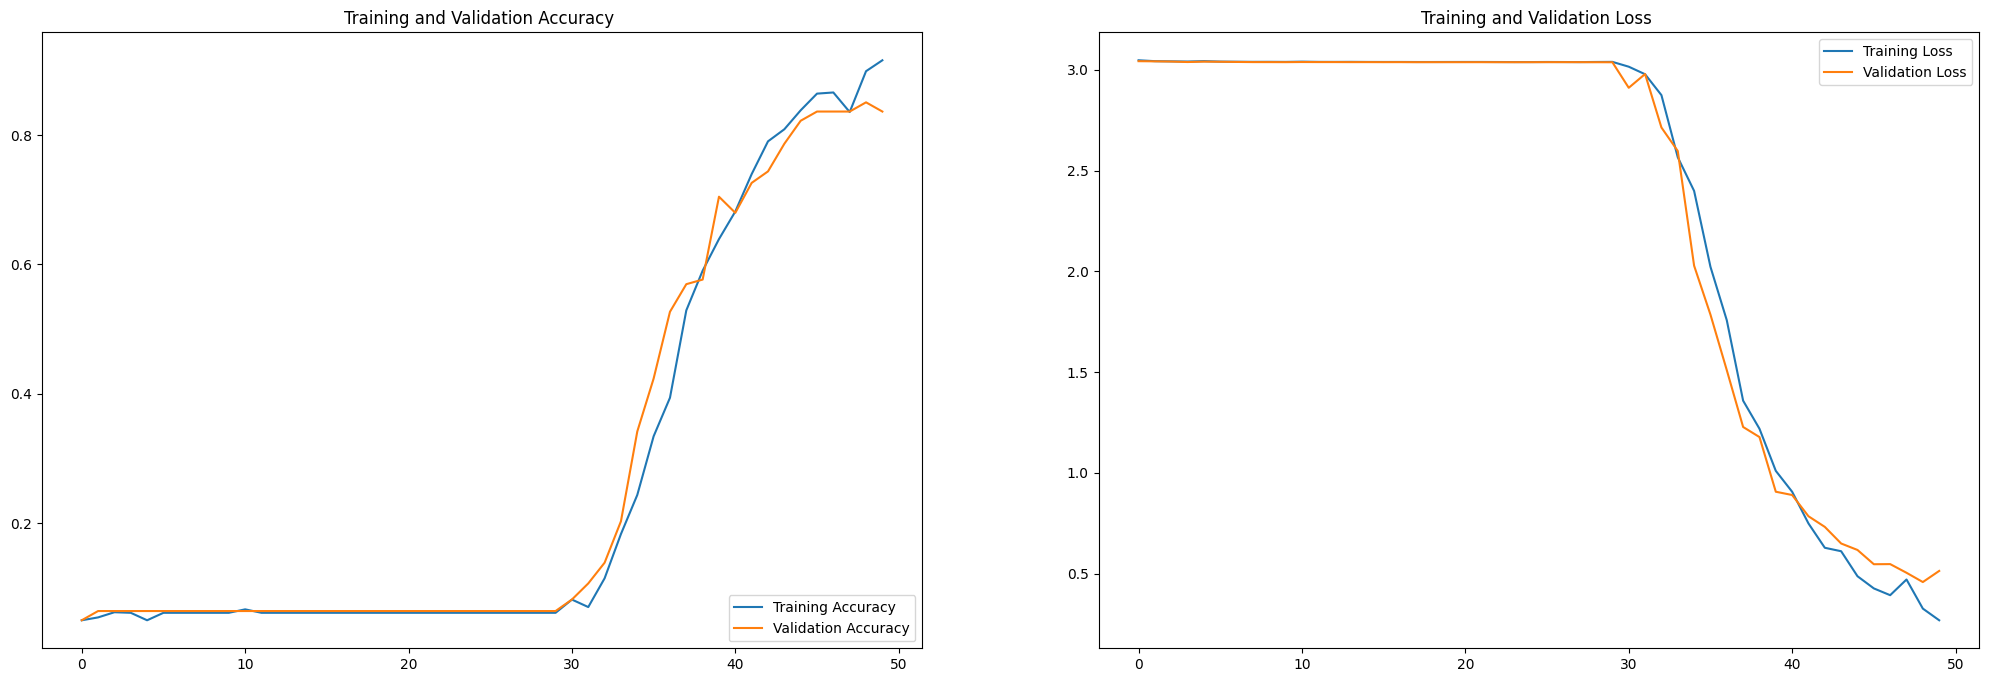

Test Accuracy 84.65909361839294
--------------------------------------------------
Fold No. 4
Found 1125 validated image filenames belonging to 21 classes.
Found 281 validated image filenames belonging to 21 classes.
Epoch 1/50
36/36 [==============================] - 6s 65ms/step - loss: 3.0495 - accuracy: 0.0444 - val_loss: 3.0431 - val_accuracy: 0.0569
Epoch 2/50
36/36 [==============================] - 2s 65ms/step - loss: 3.0417 - accuracy: 0.0587 - val_loss: 3.0405 - val_accuracy: 0.0747
Epoch 3/50
36/36 [==============================] - 3s 71ms/step - loss: 2.9764 - accuracy: 0.0702 - val_loss: 2.9198 - val_accuracy: 0.0747
Epoch 4/50
36/36 [==============================] - 2s 56ms/step - loss: 2.7891 - accuracy: 0.1129 - val_loss: 2.5778 - val_accuracy: 0.2349
Epoch 5/50
36/36 [==============================] - 2s 55ms/step - loss: 2.4018 - accuracy: 0.2462 - val_loss: 2.1846 - val_accuracy: 0.3488
Epoch 6/50
36/36 [==============================] - 2s 54ms/step - loss: 2.064

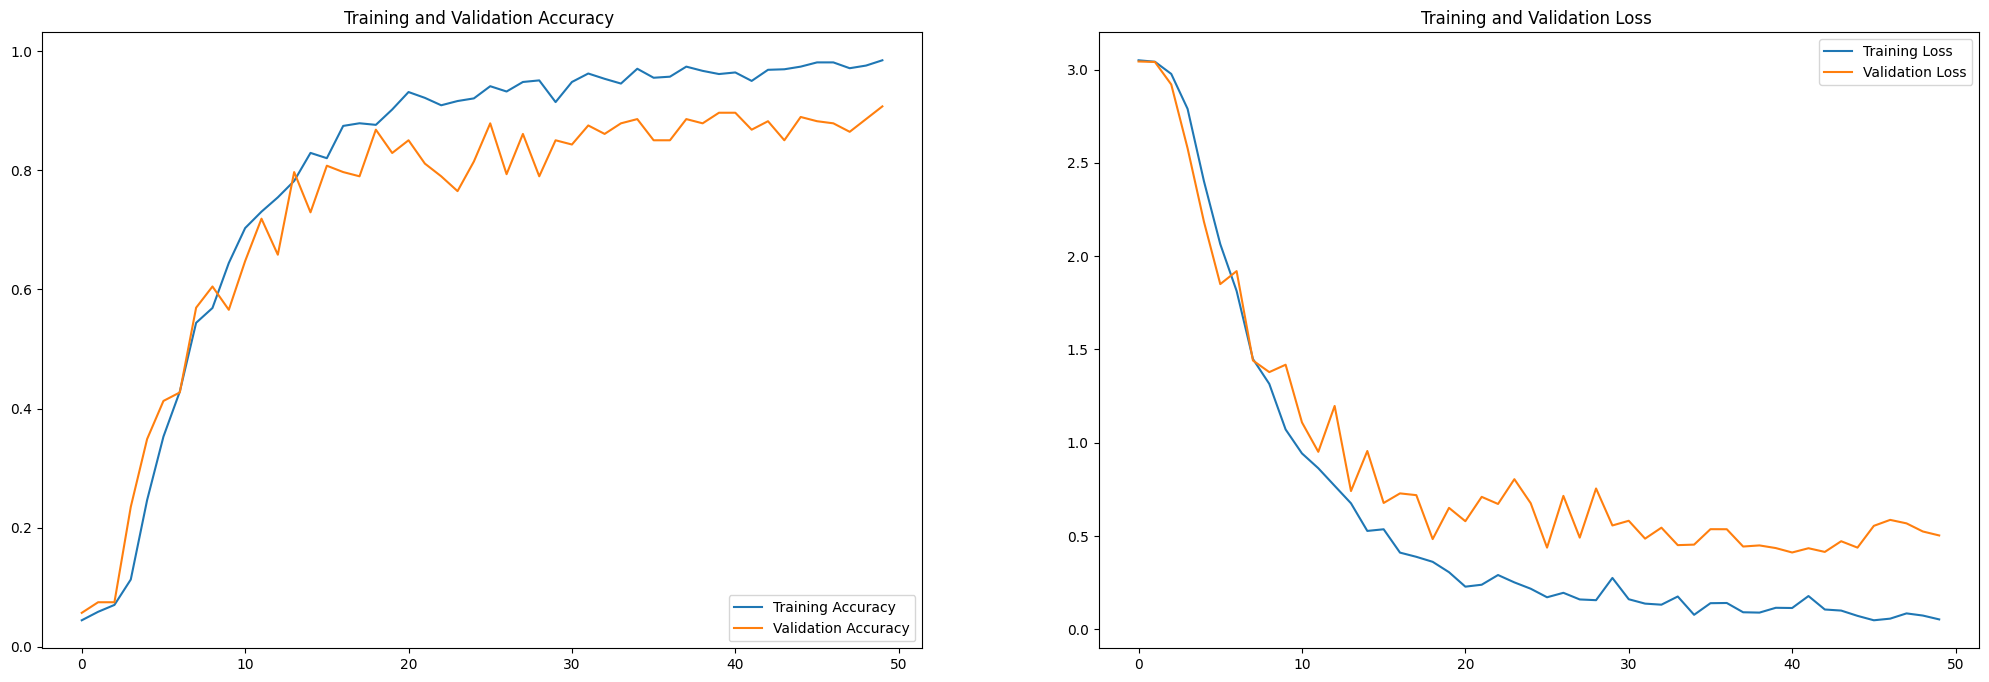

Test Accuracy 86.36363744735718
--------------------------------------------------
Fold No. 5
Found 1125 validated image filenames belonging to 21 classes.
Found 281 validated image filenames belonging to 21 classes.
Epoch 1/50
36/36 [==============================] - 7s 81ms/step - loss: 3.0498 - accuracy: 0.0524 - val_loss: 3.0434 - val_accuracy: 0.0605
Epoch 2/50
36/36 [==============================] - 2s 54ms/step - loss: 3.0438 - accuracy: 0.0596 - val_loss: 3.0425 - val_accuracy: 0.0605
Epoch 3/50
36/36 [==============================] - 2s 55ms/step - loss: 3.0423 - accuracy: 0.0622 - val_loss: 3.0413 - val_accuracy: 0.0605
Epoch 4/50
36/36 [==============================] - 2s 55ms/step - loss: 3.0420 - accuracy: 0.0560 - val_loss: 3.0405 - val_accuracy: 0.0605
Epoch 5/50
36/36 [==============================] - 2s 55ms/step - loss: 3.0409 - accuracy: 0.0622 - val_loss: 3.0394 - val_accuracy: 0.0605
Epoch 6/50
36/36 [==============================] - 3s 77ms/step - loss: 3.039

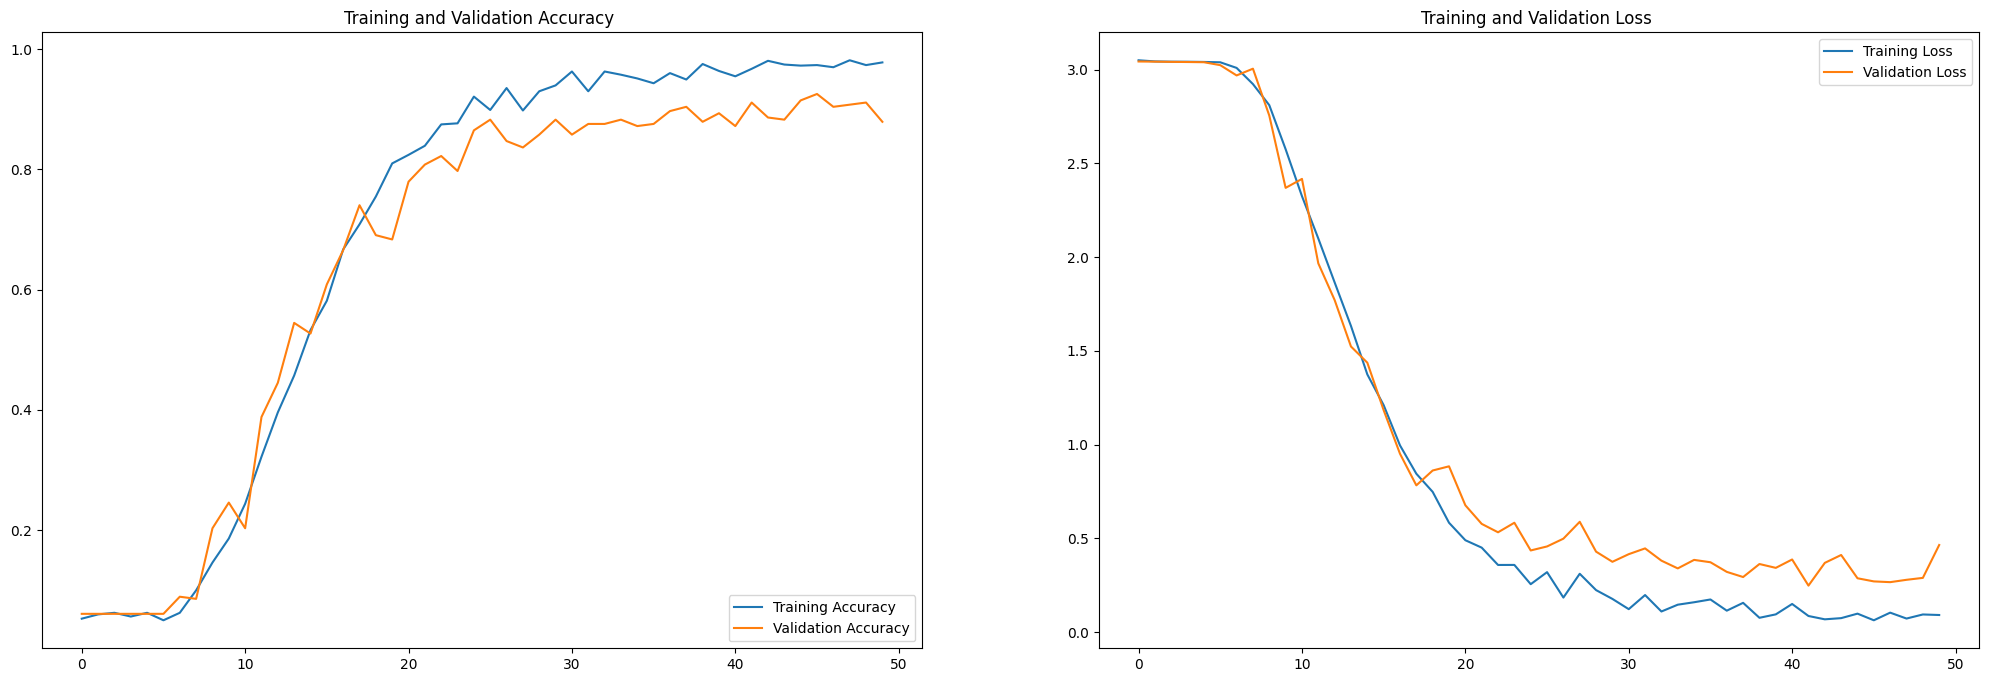

Test Accuracy 86.64772510528564
--------------------------------------------------


In [20]:
for train_idx, val_idx in kfold.split(X, Y):
    train_df = train_dataframe.iloc[train_idx]
    valid_df = train_dataframe.iloc[val_idx]
    print(f'Fold No. {fold_no}')

    training_set = datagen.flow_from_dataframe(dataframe=train_df, directory=dataset_path_img,
                        x_col='image', y_col='label',
                        target_size=(IMG_H, IMG_W), batch_size=BATCH_SIZE)

    validation_set = datagen.flow_from_dataframe(dataframe=valid_df, directory=dataset_path_img,
                        x_col='image', y_col='label',
                        target_size=(IMG_H, IMG_W), batch_size=BATCH_SIZE)

    model = create_model(NO_CLASSES)
    model.compile(
        optimizer=optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    history = model.fit(training_set, validation_data=validation_set,
                        epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    df = pd.DataFrame(data={ 'training_acc': train_acc, 'val_acc': val_acc, 'training_loss': train_loss, 'val_loss': val_loss })
    df.to_csv(f'CNN_Model_F_{fold_no}.csv')

    plot_accuracy(history, fold_no)

    model.save('content/model_fold_' + str(fold_no), save_format="h5")

    scores = model.evaluate(test_set, verbose=0)
    test_acc = scores[1] * 100
    acc_per_fold.append(test_acc)

    print(f'Test Accuracy {test_acc}')
    print('-----'*10)

    fold_no += 1

In [21]:
for idx, acc in enumerate(acc_per_fold):
    print(f'Accuracy for fold no. {idx+1} is: {acc}')

Accuracy for fold no. 1 is: 92.61363744735718
Accuracy for fold no. 2 is: 91.76136255264282
Accuracy for fold no. 3 is: 84.65909361839294
Accuracy for fold no. 4 is: 86.36363744735718
Accuracy for fold no. 5 is: 86.64772510528564


In [22]:
acc_arr = np.array(acc_per_fold)

In [23]:
acc_mean = acc_arr.mean()
acc_mean

88.40909123420715

In [24]:
acc_std = acc_arr.std()
acc_std

3.170637342989063

In [25]:
print(f'Accuracy in between {acc_mean-acc_std} to {acc_mean+acc_std}')

Accuracy in between 85.23845389121809 to 91.57972857719622
